In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt


Computing final GMM parameters...


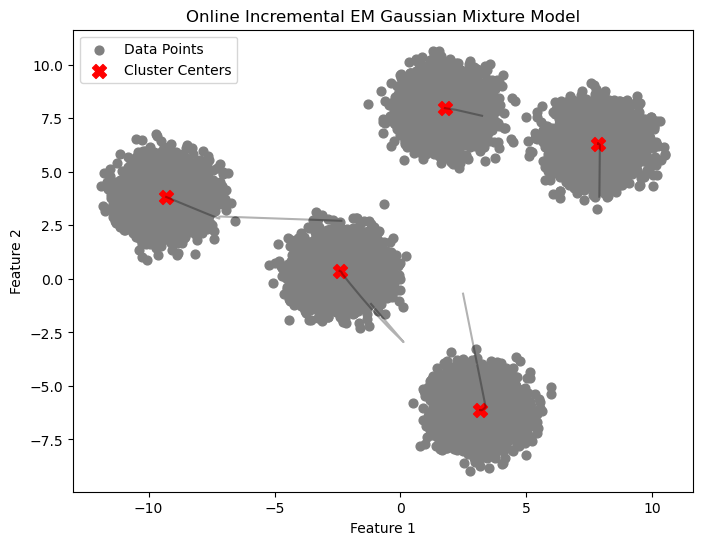

In [2]:
def initialize_parameters(n_components, n_features, first_points=None, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    pi = np.ones(n_components) / n_components
    
    # Initialize means with more spread
    if first_points is not None:
        mu_k = first_points + np.random.randn(n_components, n_features) * 2.0
    else:
        mu_k = np.random.randn(n_components, n_features) * 5.0
    
    sigma_k = np.array([
        np.eye(n_features) * (2.0 + 0.5 * k) 
        for k in range(n_components)
    ])
    
    return pi, mu_k, sigma_k

def compute_responsibilities(x, pi, mu, sigma, eps=1e-15):
    K = len(pi)
    log_responsibilities = np.zeros(K)
    
    for k in range(K):
        diff = x - mu[k]
        
        sigma_k = sigma[k] + eps * np.eye(sigma[k].shape[0])
        
        log_det = np.log(np.linalg.det(sigma_k))
        inv_sigma = np.linalg.inv(sigma_k)
        exponent = -0.5 * np.dot(diff.T, np.dot(inv_sigma, diff))
        log_responsibilities[k] = np.log(pi[k]) + exponent - 0.5 * (log_det + len(x) * np.log(2 * np.pi))
    
    log_responsibilities -= np.max(log_responsibilities)
    responsibilities = np.exp(log_responsibilities)
    responsibilities /= np.sum(responsibilities)
    
    return responsibilities

def compute_parameters(mu_stats, n_samples, reg_covar=1e-6, eps=1e-10):
    pi = np.maximum(mu_stats['N'], eps)
    pi = pi / n_samples
    
    safe_N = np.maximum(mu_stats['N'], eps)[:, None]
    mu = mu_stats['sum_x'] / safe_N
    
    # Compute covariances
    sigma = []
    for k in range(len(pi)):
        safe_N_k = max(mu_stats['N'][k], eps)
        cov = mu_stats['sum_xx'][k] / safe_N_k - np.outer(mu[k], mu[k])
        cov = (cov + cov.T) / 2
        cov.flat[::len(cov) + 1] += reg_covar
        min_eig = np.min(np.linalg.eigvals(cov))
        if min_eig < 0:
            cov.flat[::len(cov) + 1] -= min_eig - eps
        sigma.append(cov)
    
    return pi, mu, np.array(sigma)

def online_incremental_em_gmm(X, n_components=3, T=10, random_state=None):
    n_samples, n_features = X.shape
    
    pi, mu, sigma = initialize_parameters(n_components, n_features, random_state=random_state)

    mu_history = [mu.copy()]
    
    gamma = np.zeros((n_samples, n_components))
    gamma_x = np.zeros((n_samples, n_components, n_features))
    gamma_xx = np.zeros((n_samples, n_components, n_features, n_features))
    
    mu_stats = {'N': np.zeros(n_components),
                'sum_x': np.zeros((n_components, n_features)),
                'sum_xx': np.zeros((n_components, n_features, n_features))}
    
    for t in range(T):
        for idx in range(n_samples):
            x_i = X[idx]
            gamma_prime = compute_responsibilities(x_i, pi, mu, sigma)
            
            s_prime_i_gamma = gamma_prime 
            s_prime_i_gamma_x = gamma_prime[:, None] * x_i  
            s_prime_i_gamma_xx = np.array([gamma_prime[k] * np.outer(x_i, x_i) for k in range(n_components)])  
            
            mu_stats['N'] += s_prime_i_gamma - gamma[idx]  
            mu_stats['sum_x'] += s_prime_i_gamma_x - gamma_x[idx]  
            mu_stats['sum_xx'] += s_prime_i_gamma_xx - gamma_xx[idx]  
            
            gamma[idx] = s_prime_i_gamma
            gamma_x[idx] = s_prime_i_gamma_x
            gamma_xx[idx] = s_prime_i_gamma_xx
        
        pi, mu, sigma = compute_parameters(mu_stats, idx+1)
        mu_history.append(mu.copy())
        
    print("\nComputing final GMM parameters...")
    pi, mu_k, sigma_k = compute_parameters(mu_stats, idx+1)
    
    return pi, mu_k, sigma_k, mu_history

if __name__ == "__main__":
    # Generate synthetic data
    X, y_true = make_blobs(n_samples=20000, centers=5, cluster_std=0.80, random_state=20)
    X = shuffle(X, random_state=42)
    n_components = 5
    T = 15
    random_state = 42
    pi, mu_k, sigma_k, history_mu = online_incremental_em_gmm(X, n_components=n_components, T=T, random_state=random_state)
    
    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c='gray', s=40, label='Data Points')
    plt.scatter(mu_k[:, 0], mu_k[:, 1], c='red', s=100, marker='X', label='Cluster Centers')
    
    history_mu = np.array(history_mu)
    for k in range(n_components):
        plt.plot(history_mu[:, k, 0], history_mu[:, k, 1], 'k-', alpha=0.3)

    plt.title('Online Incremental EM Gaussian Mixture Model')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()


In [3]:
X_6 = np.load('./dataset/6_Gauss_Blobs.npy')


Computing final GMM parameters...


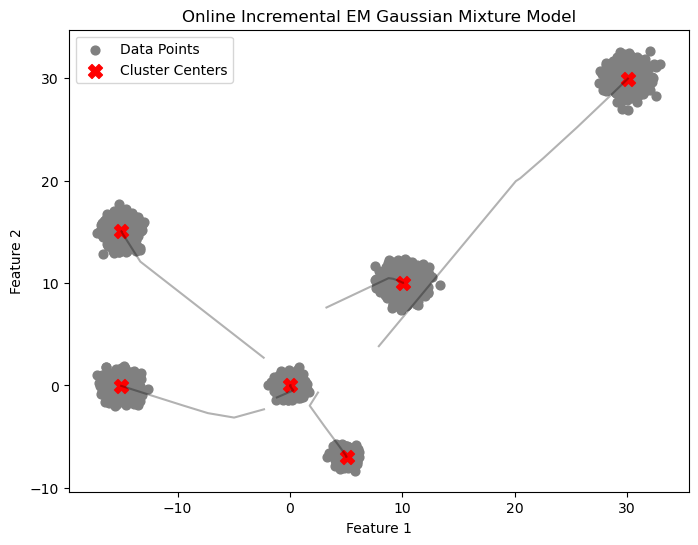

In [4]:
X = shuffle(X_6, random_state=42)
n_components = 6
T = 15
random_state = 42
pi, mu_k, sigma_k, history_mu = online_incremental_em_gmm(X, n_components=n_components, T=T, random_state=random_state)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c='gray', s=40, label='Data Points')
plt.scatter(mu_k[:, 0], mu_k[:, 1], c='red', s=100, marker='X', label='Cluster Centers')
history_mu = np.array(history_mu)
for k in range(n_components):
    plt.plot(history_mu[:, k, 0], history_mu[:, k, 1], 'k-', alpha=0.3)
plt.title('Online Incremental EM Gaussian Mixture Model')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [14]:
np.save('./results/means/gauss_blobs_iEM.npy', history_mu)

In [15]:
X_shift_add = np.load('./dataset/dist_shift_add_gaus.npy')


Computing final GMM parameters...


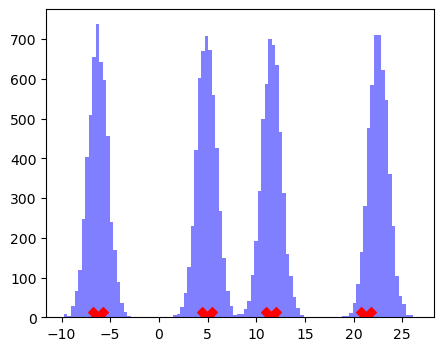

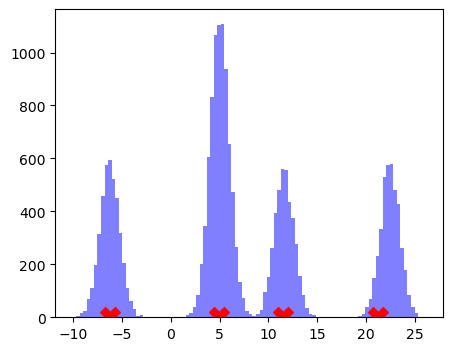

In [ ]:
n_samples = len(X_shift_add)
n_components = 4
n_features = 1

gen = X_shift_add
T = 20
random_state = 1126

pi, mu_k, sigma_k, history_mu = online_incremental_em_gmm(gen, n_components,
                                                            T, random_state)

plt.figure(figsize=(5, 4))

# plot 1d data with histogram
plt.hist(X_shift_add[:len(X_shift_add)//2], bins=100, color='blue', alpha=0.5)
plt.scatter(mu_k, np.zeros_like(mu_k), c='red', s=200, marker='X', label='Final Centers')
plt.show();

plt.figure(figsize=(5, 4))
plt.hist(X_shift_add[len(X_shift_add)//2:], bins=100, color='blue', alpha=0.5)
plt.scatter(mu_k, np.zeros_like(mu_k), c='red', s=200, marker='X', label='Final Centers')
plt.show();

In [22]:
mu_k

array([[11.50594276],
       [ 4.97640633],
       [-6.26137736],
       [21.25252339]])

In [23]:
x_shift_remove = np.load('./dataset/dist_shift_remove_gaus.npy')


Computing final GMM parameters...


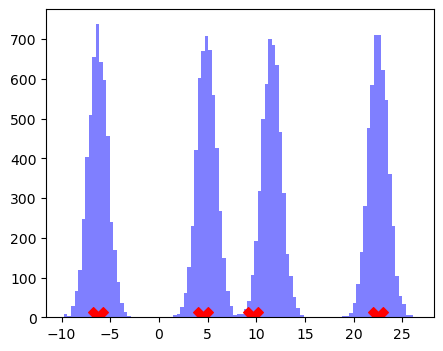

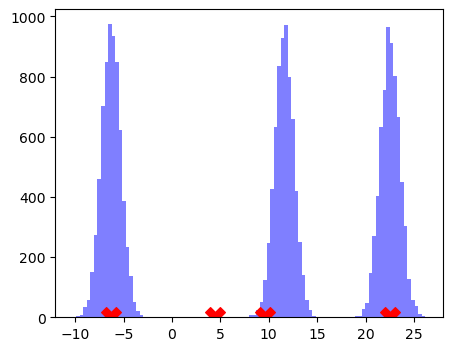

In [ ]:
n_samples = len(x_shift_remove)
n_components = 4
n_features = 1

gen = x_shift_remove
T = 20
random_state = 1126

pi, mu_k, sigma_k, history_mu = online_incremental_em_gmm(gen, n_components,
                                                            T, random_state)

plt.figure(figsize=(5, 4))

# plot 1d data with histogram
plt.hist(x_shift_remove[:len(x_shift_remove)//2], bins=100, color='blue', alpha=0.5)
plt.scatter(mu_k, np.zeros_like(mu_k), c='red', s=200, marker='X', label='Final Centers')
plt.show();

plt.figure(figsize=(5, 4))
plt.hist(x_shift_remove[len(x_shift_remove)//2:], bins=100, color='blue', alpha=0.5)
plt.scatter(mu_k, np.zeros_like(mu_k), c='red', s=200, marker='X', label='Final Centers')
plt.show();

In [25]:
mu_k

array([[ 4.49060849],
       [ 9.63560689],
       [-6.27146669],
       [22.54260899]])

In [26]:
X_shuffled = shuffled = np.load('./dataset/shuffled.npy')


Computing final GMM parameters...


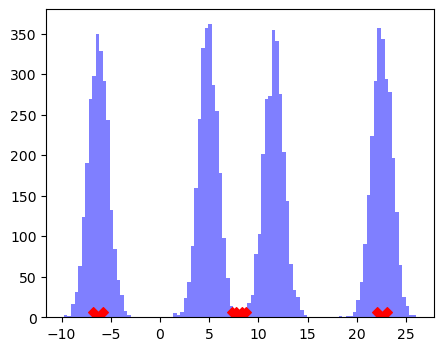

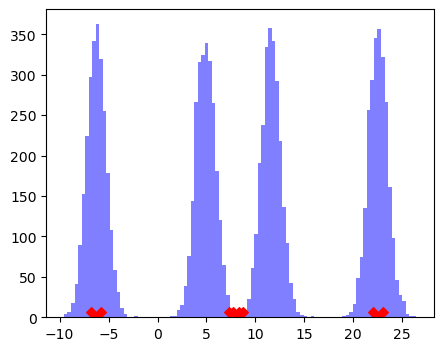

In [28]:
n_samples = len(X_shuffled)
n_components = 4
n_features = 1

gen = X_shuffled
T = 20
random_state = 1126

pi, mu_k, sigma_k, history_mu = online_incremental_em_gmm(gen, n_components,
                                                            T, random_state)

plt.figure(figsize=(5, 4))
plt.hist(X_shuffled[:len(X_shuffled)//2], bins=100, color='blue', alpha=0.5)
plt.scatter(mu_k, np.zeros_like(mu_k), c='red', s=200, marker='X', label='Final Centers')
plt.show();

plt.figure(figsize=(5, 4))
plt.hist(X_shuffled[len(X_shuffled)//2:], bins=100, color='blue', alpha=0.5)
plt.scatter(mu_k, np.zeros_like(mu_k), c='red', s=200, marker='X', label='Final Centers')
plt.show();


In [30]:
mu_k

array([[ 7.84895573],
       [ 8.22202715],
       [-6.26142708],
       [22.55335616]])